<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap13_2_embeddings_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 13 - Word Embeddings

Atenção: esse notebook foi adaptado do [tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) disponível na documentação do Keras.

## 13.1. Transferência por Aprendizado via Word2Vec

In [ ]:
!pip install keras
!pip install tensorflow
!pip install -U gensim

In [2]:
from keras.models import Sequential
from keras.layers import Dense,Embedding,Activation,Dropout,SimpleRNN,BatchNormalization,RNN,Flatten,Input,LSTM,Bidirectional
from keras.utils.np_utils import to_categorical
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import gensim
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Primeiramente, vamos importar os embeddings pré-treinados do corpus da Google, conhecido como ```GoogleNews-vectors-negative300.bin```. Esse corpus possui



In [5]:
ds_train = tfds.load('snli', split='train[50%:]', shuffle_files=True)
ds_valid = tfds.load('snli', split='validation', shuffle_files=False)
ds_test = tfds.load('snli', split='test', shuffle_files=False)

In [6]:
df_train = tfds.as_dataframe(ds_train)
df_valid = tfds.as_dataframe(ds_valid)
df_test = tfds.as_dataframe(ds_test)

In [7]:
def preprocessDataFrame(df):

    dic = {}
    dic['premise_hypothesis'] = []
    dic['label'] = []

    hypothesis = [x.decode('utf-8') for x in df['hypothesis'].values]
    premise = [x.decode('utf-8') for x in df['premise'].values]

    for idx,sentence in enumerate(premise):
        dic['premise_hypothesis'].append(premise[idx]+" "+hypothesis[idx])
        dic['label'].append(df['label'][idx])
        
    return pd.DataFrame.from_dict(dic)

In [8]:
df_train = preprocessDataFrame(df_train)
df_valid = preprocessDataFrame(df_valid)
df_test = preprocessDataFrame(df_test)

In [9]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_valid['label'] = pd.Categorical(df_valid['label'])
y_valid_int = df_valid['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

In [10]:
train_sentences = df_train['premise_hypothesis'].to_list()

vocabulary = {}

for i in range(0,len(train_sentences)):
    train_sentences[i] = train_sentences[i].lower()
    for word in train_sentences[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [11]:
tokenizer = Tokenizer(num_words = len(vocabulary))
tokenizer.fit_on_texts(df_train['premise_hypothesis'])
word2index = tokenizer.word_index
vocab_size = len(word2index)

train_sequences = tokenizer.texts_to_sequences(df_train['premise_hypothesis'])
valid_sequences = tokenizer.texts_to_sequences(df_valid['premise_hypothesis'])
test_sequences = tokenizer.texts_to_sequences(df_test['premise_hypothesis'])

In [12]:
trunc_type = 'post'
padding_type = 'post'
max_length = 64
vocab_size = len(vocabulary)

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Carregando os word embeddings

Vamos carregar os word embeddings de um modelo word2vec que foi treinado a partir do *corpus* GoogleNews, que possui aproximadamente $3$ bilhões de palavras. Cada palavra é representada por vetor de $300$ dimensões.

Como se trata de um modelo word2vec, vamos utilizar o método ```load_word2vec_format``` para carregar os pesos para um modelo word2vec. Isso ocorre por meio da classe ```KeyedVectors```. Como o arquivo desse embedding está em formato binário, devemos ajustar a flag ```binary=True```. Ademais, devido ao risco de estourarmos a memória RAM (nesse notebook), vamos limitar o vocabulário do modelo a $15000$ palavras.

In [13]:
from gensim.models import KeyedVectors

word_vectors= KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',
                                                binary=True,
                                                limit=15000)

#### Configurando a Embedding Layer para receber o Embedding word2vec 

Primeiramente, ajustamos a dimensão de saída da embedding layer que será igual à dimensão do embedding word2vec.



In [14]:
embedding_dim = len(word_vectors[0])

print(embedding_dim)

300


Fazemos agora o seguinte processo:

1.   Criamos a matriz de embeddings com dimensões "tamanho do vocabulário $\times$ dimensão da saída do embedding", inicialmente zerada:






In [15]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

2.   Como devemos configurar o embedding com os tokens do conjunto de treinamento, vamos processar palavra por palavra do *corpus* do SNLI, obter seu vetor (de dimensão ```embedding_dim```) por meio da embedding word2vec pré-treinada correspondente e incluí-la na matriz de embeddings.

**Atenção:** caso uma palavra da parte de treinamento do *corpus* seja desconhecida ao word embedding, devemos (veja o else) gerar um vetor de dimensão ```embedding_dim``` contendo valores aleatórios ou zeros. No exemplo abaixo, os valores aleatórios seguem uma distribuição normal de média zero e desvio-padrão igual a $1$.

In [16]:
for word, i in word2index.items():
    if word in word_vectors:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.normal(0,1,embedding_dim)

A embedding layer deve ser configurada da seguinte maneira para receber os pesos de um modelo word2vec que foram treinados a partir de um *corpus* grande (como o Google News ou Wikipedia):

* Colocar como ```input_dim``` o tamanho do vocabulário (cada palavra é um eixo no espaço de características) e ```output_dim``` as dimensões do embedding (e dimensão do *word vector*);
* Inicializar os pesos dos embeddings utilizando a matriz de embeddings
* É importante ajustar o parâmetro ```trainable=False``` para prevenir que os pesos da camada de Embedding sejam alterados durante o treinamento.

In [17]:
embedding_layer = Embedding(input_dim = vocab_size,
                            output_dim = embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)

Segue uma arquitetura simples para predição podemos fazer a inferência de uma premissa para uma hipótese. A adição de camadas recorrentes (SimpleRNN, LSTM, GRU) ou Densa são importantes para aprender os padrões dos dados de interesse e que estão sendo classificados (no caso, o corpus de inferência de linguagem natural):

*Homework: tente diferentes arquiteturas para melhorar os resultados obtidos nesse notebook!*

In [18]:
model = Sequential()
model.add(embedding_layer)
model.add(SimpleRNN(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 300)           13635300  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                23360     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 13,658,920
Trainable params: 23,620
Non-trainable params: 13,635,300
_________________________________________________________________


In [19]:
sgd = SGD(learning_rate=0.01)
model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
history = model.fit(train_padded,y_train,validation_data=(valid_padded,y_valid),batch_size=32,epochs=10)

Epoch 1/10
8597/8597 [==============================] - 422s 49ms/step - loss: 1.1208 - accuracy: 0.3319 - val_loss: 1.1859 - val_accuracy: 0.3328
Epoch 2/10
8597/8597 [==============================] - 415s 48ms/step - loss: 1.1107 - accuracy: 0.3329 - val_loss: 1.1844 - val_accuracy: 0.3279
Epoch 3/10
8597/8597 [==============================] - 416s 48ms/step - loss: 1.1103 - accuracy: 0.3341 - val_loss: 1.1857 - val_accuracy: 0.3237
Epoch 4/10
8597/8597 [==============================] - 419s 49ms/step - loss: 1.1098 - accuracy: 0.3332 - val_loss: 1.1839 - val_accuracy: 0.3331
Epoch 5/10
8597/8597 [==============================] - 418s 49ms/step - loss: 1.1096 - accuracy: 0.3319 - val_loss: 1.1926 - val_accuracy: 0.3279
Epoch 6/10
8597/8597 [==============================] - 412s 48ms/step - loss: 1.1092 - accuracy: 0.3345 - val_loss: 1.1831 - val_accuracy: 0.3280
Epoch 7/10
8597/8597 [==============================] - 413s 48ms/step - loss: 1.1092 - accuracy: 0.3338 - val_loss: 1

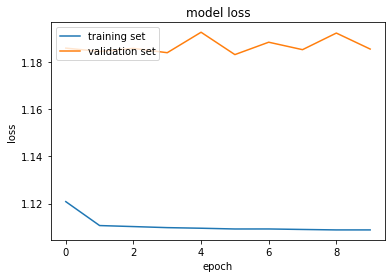

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Executando-se testes dos dados de teste:

In [21]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       176
           1       0.34      1.00      0.50      3368
           2       0.50      0.00      0.00      3219
           3       0.00      0.00      0.00      3237

    accuracy                           0.34     10000
   macro avg       0.21      0.25      0.13     10000
weighted avg       0.27      0.34      0.17     10000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
